## Model Training

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GeneralizedLinearRegression

In [2]:
# Start spark session
spark = SparkSession.builder \
    .appName("nyc_yellow_taxi_fare_prediction") \
    .config("spark.driver.memory", "24g") \
    .getOrCreate()

In [3]:
# Define file path
file_path = "df_model_input_single/df_model_input.csv"

# Create a spark dataframe
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [4]:
# Verify cols
df.printSchema()

root
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- dow: integer (nullable = true)
 |-- hour_sin: double (nullable = true)
 |-- hour_cos: double (nullable = true)
 |-- dow_sin: double (nullable = true)
 |-- dow_cos: double (nullable = true)
 |-- month_sin: double (nullable = true)
 |-- month_cos: double (nullable = true)
 |-- pickup_cluster: integer (nullable = true)
 |-- dropoff_cluster: integer (nullable = true)
 |-- same_cluster_trip: integer (nullable = true)
 |-- cluster_diff: integer (nullable = true)
 |-- distance_per_passenger: double (nullable = true)
 |-- pickup_dropoff_combo: string (nullable = true)
 |-- is_premium_route: integer (nullable = true)
 |-- cluste

In [5]:
# Check row count
df.count()

99796

In [6]:
# Check if there is any null
df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df.columns
]).show(truncate=False)

+---------------+-------------+----------+------------------+------------+------------+------------+------------+---+--------+--------+-------+-------+---------+---------+--------------+---------------+-----------------+------------+----------------------+--------------------+----------------+----------------------------+------------+----------+-------------+---------------+---------------+----------------+---------------------+------------------+-----------------------------+----------------+
|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|total_amount|dow|hour_sin|hour_cos|dow_sin|dow_cos|month_sin|month_cos|pickup_cluster|dropoff_cluster|same_cluster_trip|cluster_diff|distance_per_passenger|pickup_dropoff_combo|is_premium_route|cluster_distance_interaction|is_rush_hour|is_weekend|is_late_night|is_cash_payment|is_airport_rate|is_standard_rate|weekend_premium_route|rush_hour_distance|cluster_passenger_interaction|log_total_amount|
+-

### Define Feature Engineering Pipeline

**Strategy**

* Now that all our features are ready, we need to handle our categorical features properly before we can feed them into our models. We've got a mix of different categorical variables with very different cardinalities, so we can't just use one approach for everything.

* Looking at our categorical features, we've got three low-cardinality ones (`store_and_fwd_flag`, `RatecodeID`, `payment_type`) that have just <7 unique values each. For these, we're going with the `StringIndexer` + `OneHotEncoder` combo.

    * First, we create StringIndexers for each of these columns. The StringIndexer converts our string categories into numeric indices (like 0, 1, 2, etc.). We're using `handleInvalid="keep"` so if we encounter any new categories during prediction that weren't in our training data, it won't crash - it'll just assign them a special index.
    * Then we use OneHotEncoder to turn those numeric indices into proper binary vectors. So instead of having `payment_type = 1`, we get separate binary columns like `payment_type_vec = [0, 1, 0]`. We set `dropLast=True` to avoid the dummy variable trap - basically preventing multicollinearity by dropping one of the binary columns.

* Now for our high-cardinality categorical (`pickup_dropoff_combo`), we can't use one-hot encoding because it would explode our feature space. This thing has 81 unique route combinations. If we one-hot encoded it, we'd get 81 new columns, which is way too much.

* Instead, we use `FeatureHasher` to map all those route combinations into a fixed-size vector space of 1000 features. It uses hash functions to distribute the categories across this space, so we keep most of the information but in a much more manageable form.

In [7]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, FeatureHasher, StandardScaler

# Define low-cardinality cat cols
low_card_cols = ["store_and_fwd_flag", "RatecodeID", "payment_type"]

# Create StringIndexers for categorical columns 
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in low_card_cols
]

# Create OneHotEncoder to convert indexed categories to binary vectors
ohe = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in low_card_cols],
    outputCols=[f"{c}_vec" for c in low_card_cols],
    dropLast=True
)

# Define high-cardinality cat cols
high_card_cols = ["pickup_dropoff_combo"]

# Create FeatureHasher for high-cardinality cat col
hasher = FeatureHasher(
    inputCols=high_card_cols,
    outputCol="cluster_combo_hashed",
    numFeatures=1000
)

**Strategy**

* Now we need to put all our features together into one big vector that our models can actually use. Our `numeric_cols` list includes the basics like `passenger_count` and `trip_distance`, plus all the time encodings we created (`hour_sin/cos`, `dow_sin/cos`, `month_sin/cos`), our cluster features, and all those interaction terms we built to capture complex pricing patterns.

* The `VectorAssembler` is going to combine three types of features:
    * All our numerical columns (24 of them)
    * The one-hot encoded categorical vectors from our low-cardinality features 
    * The hashed representation of our high-cardinality `pickup_dropoff_combo`

* We're calling the output `raw_features` because we still need to scale everything. Different features have wildly different ranges - trip distance might be 0-20 miles while our interaction terms could be much larger numbers.

* That's where `StandardScaler` comes in. We're using both `withMean=True` and `withStd=True` to center everything around zero and scale to unit variance. This is crucial for Linear Regression to work properly and helps all our models converge better during training.

* The final `features` column will be what we actually feed into our models, a nicely scaled, properly formatted feature vector ready for machine learning.

In [8]:
# Assemble all numerical and engineered features
numeric_cols = [
    "passenger_count", "trip_distance",
    "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
    "pickup_cluster", "dropoff_cluster", "same_cluster_trip", "cluster_diff",
    "distance_per_passenger", "is_premium_route", "cluster_distance_interaction",
    "is_rush_hour", "is_weekend", "is_late_night",
    "is_cash_payment", "is_airport_rate", "is_standard_rate",
    "weekend_premium_route", "rush_hour_distance", "cluster_passenger_interaction"
]

# Define VectorAssembler with correct variable names
assembler = VectorAssembler(
    inputCols=(
        numeric_cols
        + [f"{c}_vec" for c in low_card_cols]  # outputs from ohe
        + ["cluster_combo_hashed"] # output from hasher
    ),
    outputCol="raw_features"
)

# Define StandardScaler for scaling
scaler = StandardScaler(
    inputCol="raw_features",
    outputCol="features",
    withMean=True,
    withStd=True
)

### Split Data into Training and Test sets

In [9]:
# Split the dataset with all engineered features
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Set target column
target_col = "log_total_amount"

# Show dataset sizes
print(f"Training data count: {train_data.count()}")
print(f"Test data count: {test_data.count()}")

Training data count: 79986
Test data count: 19810


### Create feature engineering pipeline

In [10]:
# Create complete feature engineering pipeline and apply it
feature_pipeline = Pipeline(stages=indexers + [ohe, hasher, assembler, scaler])

# Fit the pipeline on training data
fitted_pipeline = feature_pipeline.fit(train_data)

# Transform both training and test data
train_features = fitted_pipeline.transform(train_data)
test_features = fitted_pipeline.transform(test_data)

# Verify the features column was created
print("Training features schema:")
train_features.select("features").printSchema()
print(f"Feature vector size: {len(train_features.select('features').first()[0])}")

Training features schema:
root
 |-- features: vector (nullable = true)

Feature vector size: 1038


### Initialize and Configure Models

In [11]:
# Define models
lr = LinearRegression(featuresCol="features", labelCol=target_col, elasticNetParam=0.0)
rf = RandomForestRegressor(featuresCol="features", labelCol=target_col, maxDepth=10, numTrees=100, seed=42)
dt = DecisionTreeRegressor(featuresCol="features", labelCol=target_col, maxDepth=10, seed=42)
gbt = GBTRegressor(featuresCol="features", labelCol=target_col, maxDepth=10, maxIter=100, seed=42)

# Add distance-based model using Generalized Linear Regression with appropriate family
glr = GeneralizedLinearRegression(
    featuresCol="features", 
    labelCol=target_col,
    family="gaussian", # For continuous target
    link="identity", # Linear relationship
    maxIter=100
)

In [12]:
# Create pipeline for each model
baseline_models = {
    "LinearRegression": lr,
    "RandomForestRegressor": rf, 
    "DecisionTreeRegressor": dt,
    "GBTRegressor": gbt,
    "GeneralizedLinearRegression": glr,
}

### Train each model

In [13]:
def train_models(models_dict, train_data):
    """
    Trains each model in the dictionary on the provided training data.

    Args:
        models_dict (dict): Dictionary of model_name and untrained model/pipeline.
        train_data (DataFrame): Training dataset.

    Returns:
        trained_models (dict): Dictionary mapping model names to trained models.
    """
    # Initialize trained_models
    trained_models = {}

    # Train each model
    for model_name, model in models_dict.items():
        print(f"Training {model_name}...")
        
        # Train the model
        trained_model = model.fit(train_data)

        # Add to trained_models dict
        trained_models[model_name] = trained_model

        # Print confirmation
        print(f"{model_name} trained successfully!")

    return trained_models

In [14]:
# Train models using transformed data (train_features)
trained_models = train_models(baseline_models, train_features)

Training LinearRegression...
LinearRegression trained successfully!
Training RandomForestRegressor...
RandomForestRegressor trained successfully!
Training DecisionTreeRegressor...
DecisionTreeRegressor trained successfully!
Training GBTRegressor...
GBTRegressor trained successfully!
Training GeneralizedLinearRegression...
GeneralizedLinearRegression trained successfully!


## Model Evaluation

### Initialize Evaluators and Predictions

In [15]:
# Initialize evaluators
rmse_evaluator = RegressionEvaluator(labelCol=target_col, metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol=target_col, metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol=target_col, metricName="r2")

### Evaluate Baseline Models

In [16]:
def evaluate_models(trained_models, test_data, rmse_evaluator, mae_evaluator, r2_evaluator):
    """
    Predict and evaluate each trained model on the given test data.

    Args:
        trained_models (dict): Dictionary of trained models with model names as keys.
        test_data (DataFrame): Spark DataFrame to make predictions on.
        rmse_evaluator (RegressionEvaluator): Evaluator for computing RMSE.
        mae_evaluator (RegressionEvaluator): Evaluator for computing MAE.
        r2_evaluator (RegressionEvaluator): Evaluator for computing R².

    Returns:
        model_predictions (dict): Dictionary of model predictions keyed by model name.
        results (list): List of tuples containing (model_name, rmse, mae, r2).
    """
    # Initialize predictions dictionary
    model_predictions = {}
    # Initialize results list
    results = []

    # Predict and evaluate each trained model
    for model_name, model in trained_models.items():
        print(f"Evaluating {model_name}...")
        
        # Make predictions and save to dict
        predictions = model.transform(test_data)
        model_predictions[model_name] = predictions

        # Compute evaluation metrics: RMSE, MAE, R²
        rmse = rmse_evaluator.evaluate(predictions)
        mae = mae_evaluator.evaluate(predictions)
        r2 = r2_evaluator.evaluate(predictions)
        
        results.append((model_name, rmse, mae, r2))

        # Print each result
        print(f"{model_name}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}\n")

    return model_predictions, results

In [17]:
# Evaluate on test data using trained_models
print("Evaluate Baseline Models on Test Set")
baseline_predictions, baseline_results = evaluate_models(
    trained_models,
    test_features,
    rmse_evaluator,
    mae_evaluator,
    r2_evaluator
)

Evaluate Baseline Models on Test Set
Evaluating LinearRegression...
LinearRegression: RMSE=0.216, MAE=0.137, R²=0.708

Evaluating RandomForestRegressor...
RandomForestRegressor: RMSE=0.182, MAE=0.114, R²=0.792

Evaluating DecisionTreeRegressor...
DecisionTreeRegressor: RMSE=0.188, MAE=0.116, R²=0.776

Evaluating GBTRegressor...
GBTRegressor: RMSE=0.188, MAE=0.113, R²=0.778

Evaluating GeneralizedLinearRegression...
GeneralizedLinearRegression: RMSE=0.216, MAE=0.137, R²=0.708



### Compare model performance

In [18]:
# Convert to DataFrame
results_df = pd.DataFrame(baseline_results, columns=["Model", "RMSE", "MAE", "R2"])

# Sort by R2
results_df_sorted = results_df.sort_values(by="R2", ascending=False)

# Print as a table
print("Baseline Models Comparison (sorted by R2):")
print(results_df_sorted.to_string(index=False))

Baseline Models Comparison (sorted by R2):
                      Model     RMSE      MAE       R2
      RandomForestRegressor 0.181635 0.114417 0.792429
               GBTRegressor 0.187782 0.112889 0.778141
      DecisionTreeRegressor 0.188495 0.115786 0.776453
           LinearRegression 0.215503 0.136694 0.707803
GeneralizedLinearRegression 0.215503 0.136694 0.707803


In [19]:
# Create a performance ranking table
performance_ranking = results_df.copy()

# Rank models (1 = best)
performance_ranking['RMSE_Rank'] = performance_ranking['RMSE'].rank()
performance_ranking['MAE_Rank'] = performance_ranking['MAE'].rank()
performance_ranking['R2_Rank'] = performance_ranking['R2'].rank(ascending=False)

# Calculate average rank
performance_ranking['Avg_Rank'] = (
    performance_ranking['RMSE_Rank'] + 
    performance_ranking['MAE_Rank'] + 
    performance_ranking['R2_Rank']
) / 3

# Sort by average rank
performance_ranking = performance_ranking.sort_values('Avg_Rank')

print("\n" + "="*100)
print("MODEL PERFORMANCE RANKING (1 = Best)")
print("="*100)
print(performance_ranking[['Model', 'RMSE', 'MAE', 'R2', 'RMSE_Rank', 'MAE_Rank', 'R2_Rank', 'Avg_Rank']].to_string(index=False))


MODEL PERFORMANCE RANKING (1 = Best)
                      Model     RMSE      MAE       R2  RMSE_Rank  MAE_Rank  R2_Rank  Avg_Rank
      RandomForestRegressor 0.181635 0.114417 0.792429        1.0       2.0      1.0  1.333333
               GBTRegressor 0.187782 0.112889 0.778141        2.0       1.0      2.0  1.666667
      DecisionTreeRegressor 0.188495 0.115786 0.776453        3.0       3.0      3.0  3.000000
           LinearRegression 0.215503 0.136694 0.707803        4.0       4.0      4.0  4.000000
GeneralizedLinearRegression 0.215503 0.136694 0.707803        5.0       5.0      5.0  5.000000


### Visualize actual vs predicted plots for each model

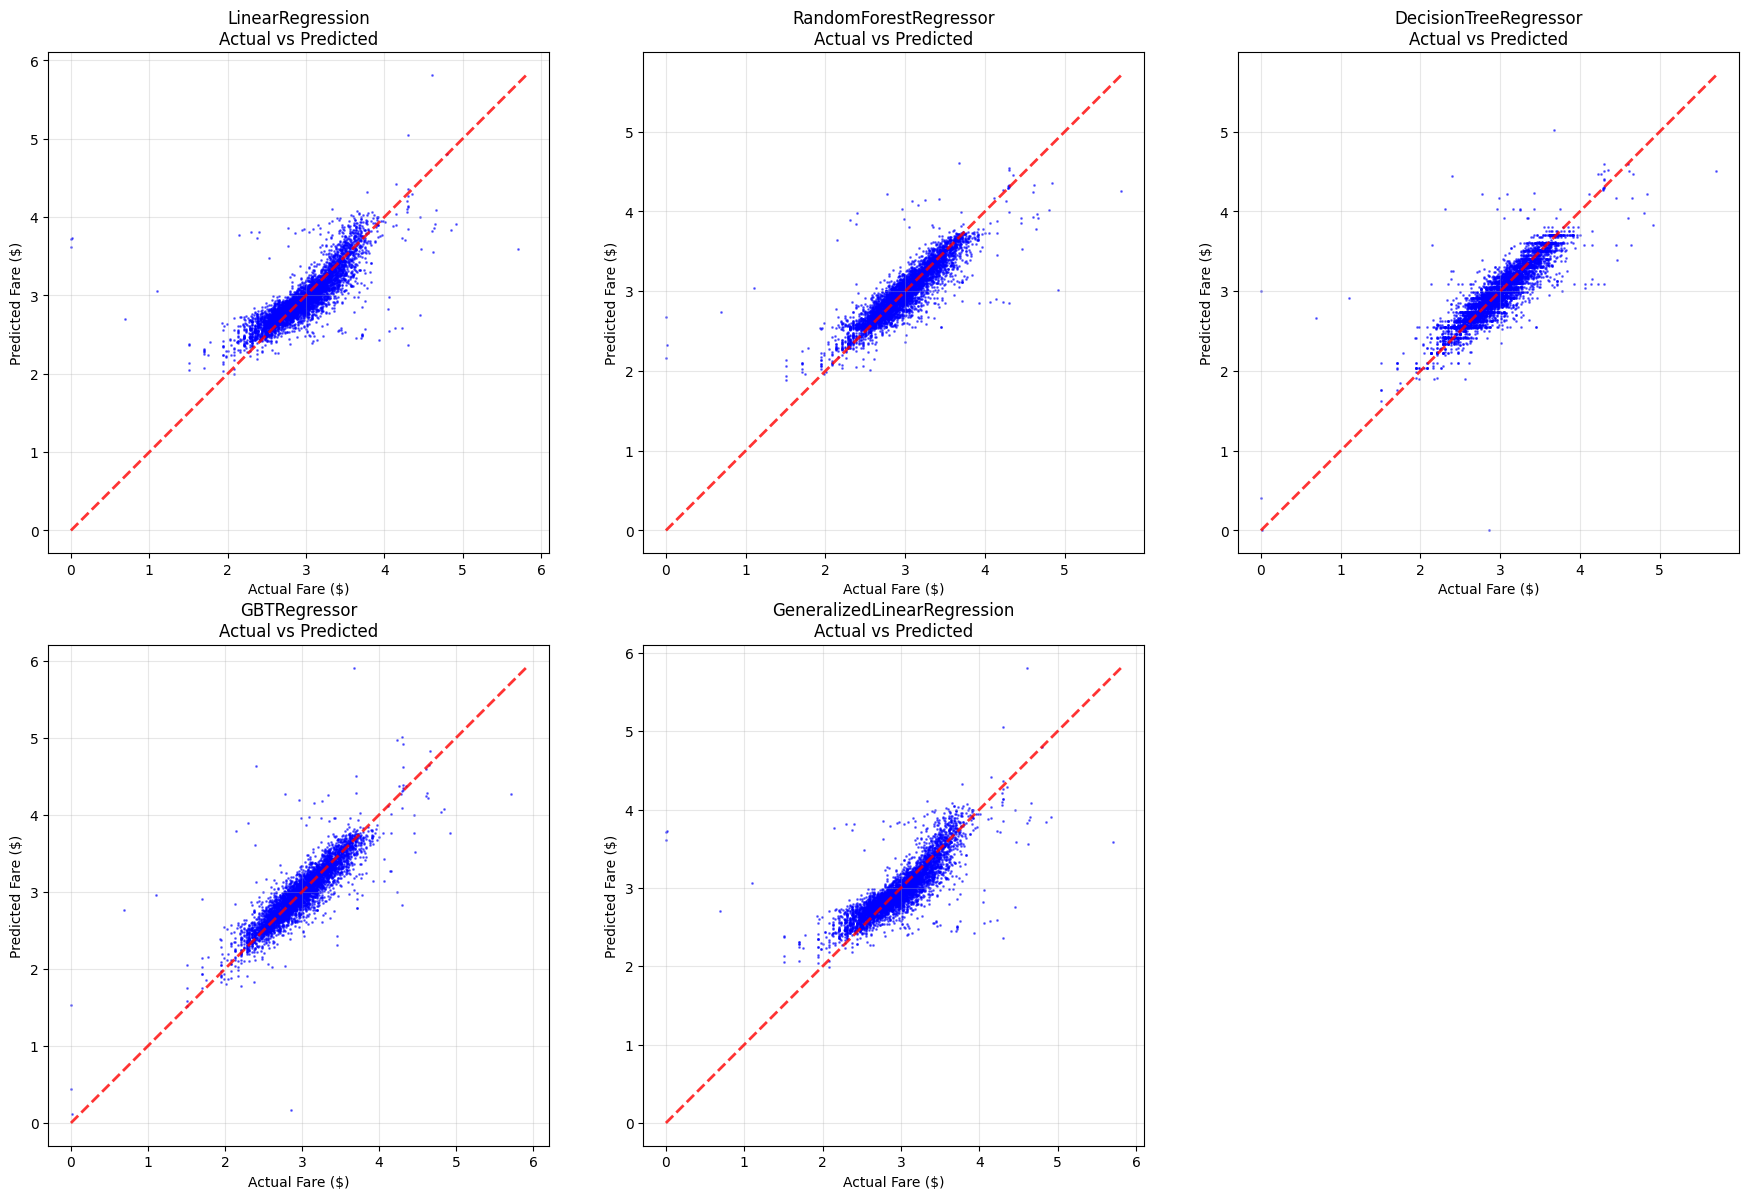

In [20]:
import matplotlib.pyplot as plt

# Create actual vs predicted plots for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (model_name, predictions_df) in enumerate(baseline_predictions.items()):
    # Convert Spark DataFrame to Pandas for plotting
    plot_data = predictions_df.select('log_total_amount', 'prediction').toPandas()
    
    # Sample data for better visualization
    plot_data = plot_data.sample(n=5000, random_state=42)
    
    # Create scatter plot
    axes[idx].scatter(plot_data['log_total_amount'], plot_data['prediction'], 
                     alpha=0.5, s=1, color='blue')
    
    # Add perfect prediction line (y=x)
    min_val = min(plot_data['log_total_amount'].min(), plot_data['prediction'].min())
    max_val = max(plot_data['log_total_amount'].max(), plot_data['prediction'].max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8)
    
    # Set labels and title
    axes[idx].set_xlabel('Actual Fare ($)')
    axes[idx].set_ylabel('Predicted Fare ($)')
    axes[idx].set_title(f'{model_name}\nActual vs Predicted')
    axes[idx].grid(True, alpha=0.3)
    
    # Set equal aspect ratio
    axes[idx].set_aspect('equal', adjustable='box')

# Hide the last subplot if we have fewer than 6 models
if len(baseline_predictions) < 6:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

### Visualize feature importance analysis for tree-based models

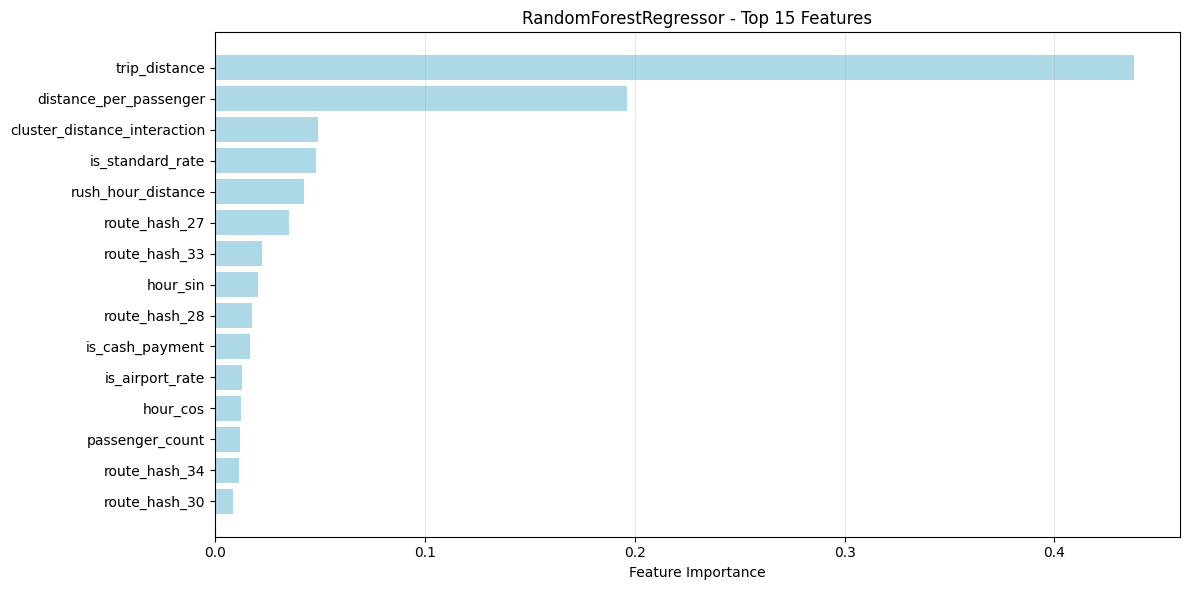

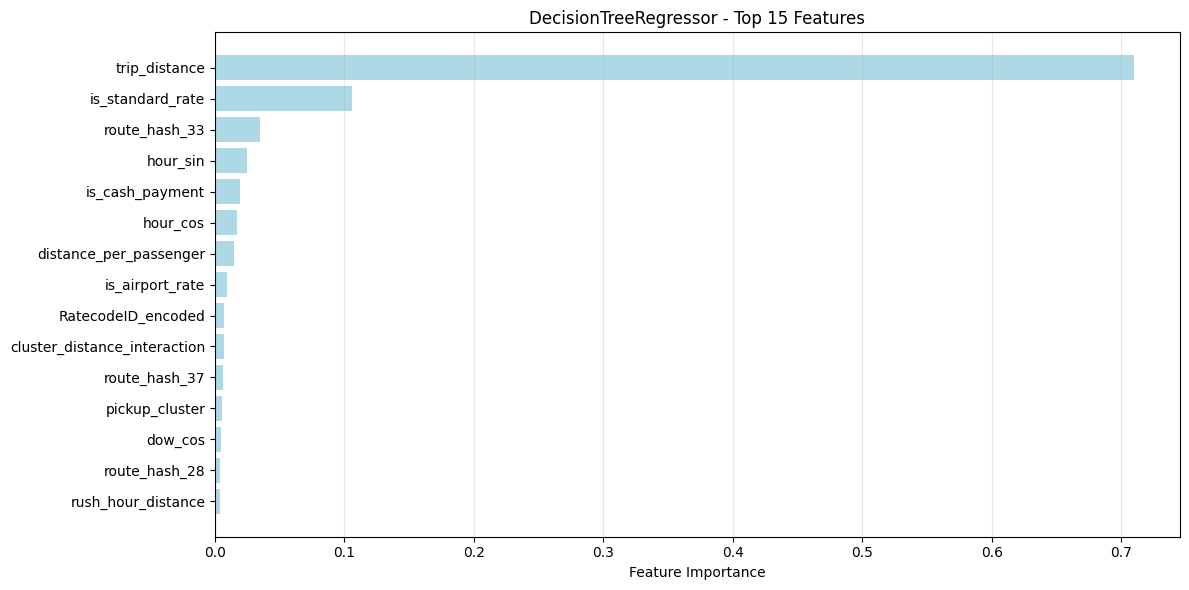

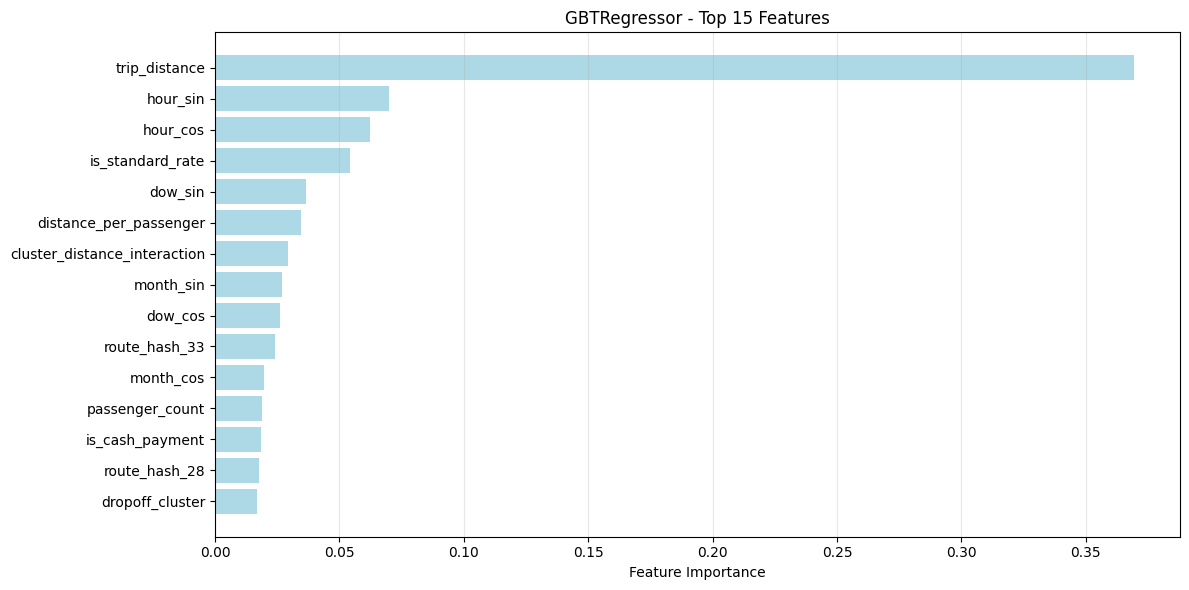

In [21]:
# Define tree-based models that have feature importance
tree_models = ["RandomForestRegressor", "DecisionTreeRegressor", "GBTRegressor"]

# Create feature name mapping
feature_names_map = {}
idx = 0

# Add numeric features (0-23)
for col in numeric_cols:
    feature_names_map[idx] = col
    idx += 1

# Add one-hot encoded features (24-33)
for col in low_card_cols:
    feature_names_map[idx] = f"{col}_encoded"
    idx += 1

# Extract and visualize feature importance for each tree-based model
for model_name in tree_models:
    if model_name in trained_models:        
        model = trained_models[model_name]
        importances = model.featureImportances.toArray()
        
        # Get top 15 features with names
        top_indices = importances.argsort()[-15:][::-1]
                
        # Create plot
        plt.figure(figsize=(12, 6))
        feature_labels = [feature_names_map.get(idx, f"route_hash_{idx}") for idx in top_indices]
        
        plt.barh(range(len(top_indices)), importances[top_indices], color='lightblue')
        plt.yticks(range(len(top_indices)), feature_labels)
        plt.xlabel('Feature Importance')
        plt.title(f'{model_name} - Top 15 Features')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

### Visualize residual analysis plots

RandomForestRegressor - Mean residual: 18.256, Std: 10.336
DecisionTreeRegressor - Mean residual: 18.258, Std: 10.325
GBTRegressor - Mean residual: 18.257, Std: 10.314


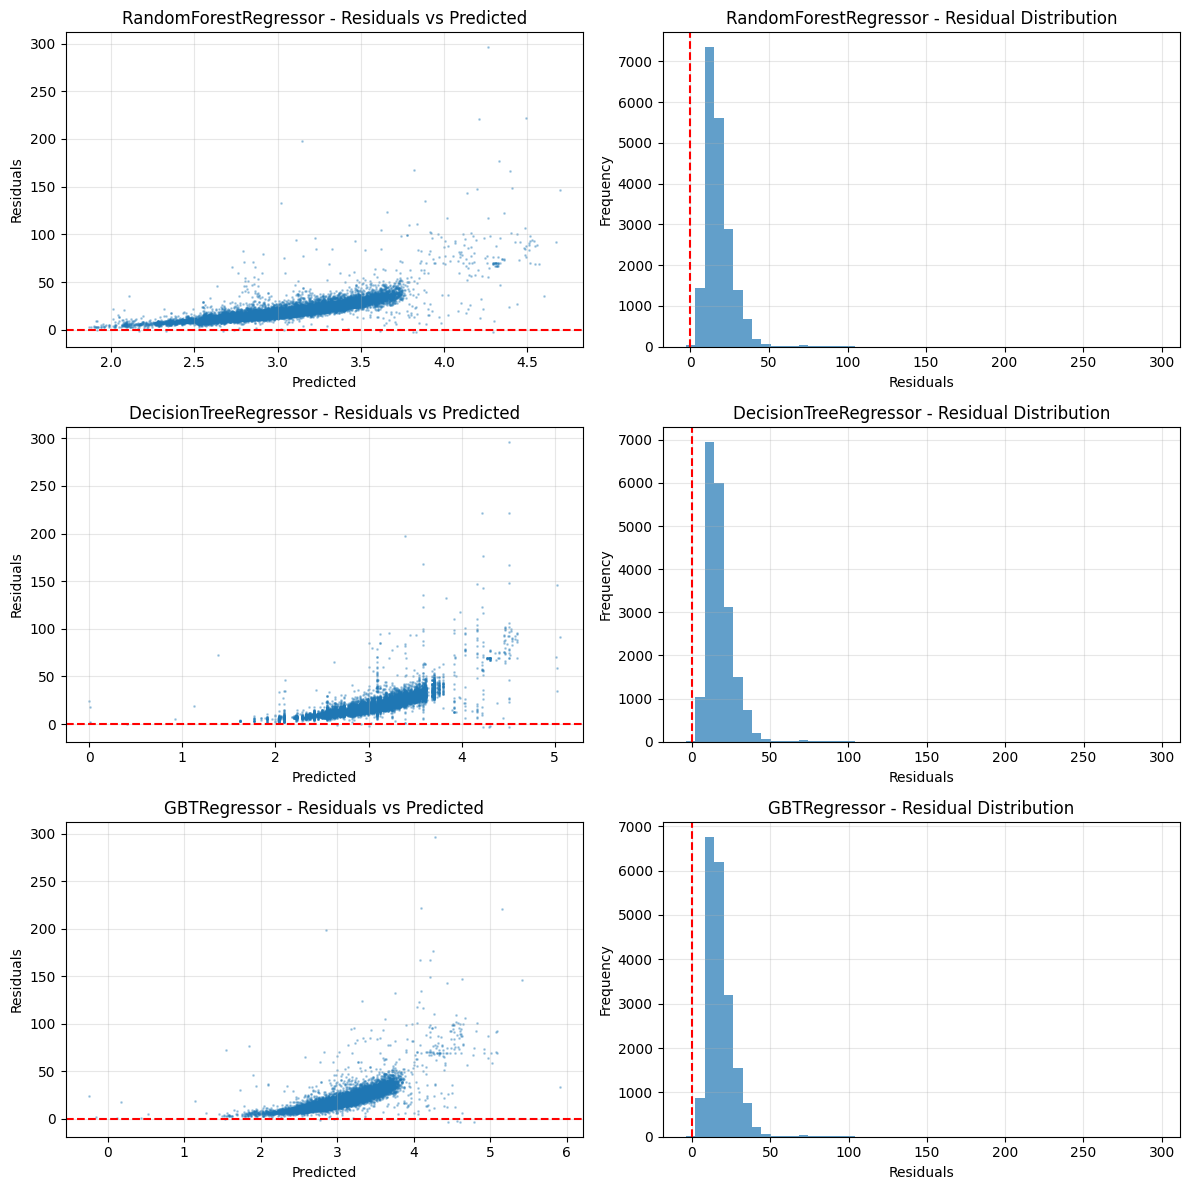

In [22]:
# Create residual plots for all tree models
fig, axes = plt.subplots(len(tree_models), 2, figsize=(12, 4*len(tree_models)))

for i, model_name in enumerate(tree_models):
    # Get predictions
    predictions_df = baseline_predictions[model_name].select('total_amount', 'prediction').toPandas()
    predictions_df['residuals'] = predictions_df['total_amount'] - predictions_df['prediction']
    
    # Residuals vs Predicted
    axes[i, 0].scatter(predictions_df['prediction'], predictions_df['residuals'], alpha=0.3, s=1)
    axes[i, 0].axhline(y=0, color='red', linestyle='--')
    axes[i, 0].set_xlabel('Predicted')
    axes[i, 0].set_ylabel('Residuals')
    axes[i, 0].set_title(f'{model_name} - Residuals vs Predicted')
    axes[i, 0].grid(True, alpha=0.3)
    
    # Residual histogram
    axes[i, 1].hist(predictions_df['residuals'], bins=50, alpha=0.7)
    axes[i, 1].axvline(x=0, color='red', linestyle='--')
    axes[i, 1].set_xlabel('Residuals')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].set_title(f'{model_name} - Residual Distribution')
    axes[i, 1].grid(True, alpha=0.3)
    
    # Print stats
    print(f"{model_name} - Mean residual: {predictions_df['residuals'].mean():.3f}, Std: {predictions_df['residuals'].std():.3f}")

plt.tight_layout()
plt.show()

### Get best model

In [23]:
# Create residual plots for the best model
best_model = performance_ranking.iloc[0]['Model']
print("Best model is", best_model)
best_predictions = baseline_predictions[best_model].select('total_amount', 'prediction').toPandas()

Best model is RandomForestRegressor


In [24]:
# Export the best model
import os

best_model_obj = trained_models[best_model]

# Create directory if it doesn't exist
os.makedirs("trained_models", exist_ok=True)
best_model_path = f"trained_models/{best_model}_best"

# Save the best model
best_model_obj.write().overwrite().save(best_model_path)
print(f"Best model '{best_model}' exported to {best_model_path}")

Best model 'RandomForestRegressor' exported to trained_models/RandomForestRegressor_best
